In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 18})
import seaborn as sns
import regex as re
import os
import numpy as np
from ast import literal_eval

In [15]:
plt.rcParams.update({'font.size': 16})

In [ ]:
! cd ../results && pwd && find ~+ -type f -name "parameters.txt"

In [3]:
result_paths = {
    '500': "/mnt/extra/continuous-training/results/1718056102046315874/",
    '1000': "/mnt/extra/continuous-training/results/1718055647632046086/",
    '5000': "/mnt/extra/continuous-training/results/1718056537436439889/",
    '10000': "/mnt/extra/continuous-training/results/1718047868890523352/",
}

In [7]:
stats_df = pd.DataFrame(columns=['folder_path', 'algo', 'threshold', 'param_path', 'csv_path', 'latencies_path', 'num_retrain', 'training_time_total', 'training_time_single', 'training_cpu_time', 'training_counter', 'inference_time_total', 'inference_time_single', 'inference_cpu_time', 'inference_counter'])

for key, stat in result_paths.items():
    contents = []
    with open(os.path.join(stat, 'parameters.txt'), "r") as f:
        contents = f.readlines()
    # Iterate to get variables
    folder_path = stat
    algo_name = 'nurd'
    csv_path = os.path.join(folder_path, 'model_zoo_sample_'+str(key)+'.csv')
    latencies_path = os.path.join(folder_path, 'latencies.csv')
    param_path = stat
    valid_entry = False
    retrained = -1
    training_time_total = -1
    training_time_single = -1
    training_cpu_time = -1
    training_counter = -1
    inference_time_total = -1
    inference_time_single = -1
    inference_cpu_time = -1
    inference_counter = -1
    for content in contents:
        if not valid_entry and 'Inference' in content:
            valid_entry = True
        if 'Retrained' in content:
            retrained = float(content.split(' = ')[1].split('\n')[0])
        if 'Training time total' in content:
            training_time_total = float(content.split(' = ')[1].split(' s')[0])
        if 'Training time single' in content:
            training_time_single = float(content.split(' = ')[1].split(' s')[0])
        if 'Training CPU times usage' in content:
            training_cpu_time = float(content.split(' = ')[1].split(' sCPU')[0])
        if 'Training counter' in content:
            training_counter = float(content.split(' = ')[1].split('\n')[0])
        if 'Inference time total' in content:
            inference_time_total = float(content.split(' = ')[1].split(' s')[0])
        if 'Inference time single' in content:
            inference_time_single = float(content.split(' = ')[1].split(' s')[0])
        if 'Inference CPU times usage' in content:
            inference_cpu_time = float(content.split(' = ')[1].split(' sCPU')[0])
        if 'Inference counter' in content:
            inference_counter = float(content.split(' = ')[1].split('\n')[0])
    if valid_entry:
        stats_df.loc[len(stats_df)] = [folder_path, algo_name, key, param_path, csv_path, latencies_path, retrained, training_time_total, training_time_single, training_cpu_time, training_counter, inference_time_total, inference_time_single, inference_cpu_time, inference_counter]
stats_df

,folder_path,algo,threshold,param_path,csv_path,latencies_path,num_retrain,training_time_total,training_time_single,training_cpu_time,training_counter,inference_time_total,inference_time_single,inference_cpu_time,inference_counter
0,/mnt/extra/continuous-training/results/1718056...,nurd,500,/mnt/extra/continuous-training/results/1718056...,/mnt/extra/continuous-training/results/1718056...,/mnt/extra/continuous-training/results/1718056...,0.0,127.971852,8.531457,873.73,15.0,7.741145,5.234433e-07,48.11,14788890.0
1,/mnt/extra/continuous-training/results/1718055...,nurd,1000,/mnt/extra/continuous-training/results/1718055...,/mnt/extra/continuous-training/results/1718055...,/mnt/extra/continuous-training/results/1718055...,0.0,141.154677,9.410312,1481.23,15.0,7.750308,5.240629e-07,43.95,14788890.0
2,/mnt/extra/continuous-training/results/1718056...,nurd,5000,/mnt/extra/continuous-training/results/1718056...,/mnt/extra/continuous-training/results/1718056...,/mnt/extra/continuous-training/results/1718056...,0.0,120.827388,8.055159,375.82,15.0,7.599934,5.138948e-07,29.58,14788890.0
3,/mnt/extra/continuous-training/results/1718047...,nurd,10000,/mnt/extra/continuous-training/results/1718047...,/mnt/extra/continuous-training/results/1718047...,/mnt/extra/continuous-training/results/1718047...,0.0,113.666318,7.577755,343.84,15.0,7.273192,4.918011e-07,15.13,14788890.0


In [8]:
values_df = pd.DataFrame({
    'threshold': pd.Series(dtype='int'),
    'path': pd.Series(dtype='string'),
    'algo': pd.Series(dtype='string'),
    'length': pd.Series(dtype='int'),
    'f1': pd.Series(dtype='object'),
    'roc_auc': pd.Series(dtype='object'),
    'latencies_acc': pd.Series(dtype='object'),
    'latencies_rej': pd.Series(dtype='object'),
    'retrain': pd.Series(dtype='int'),
    'training_time_total': pd.Series(dtype='float'),
    'training_time_single': pd.Series(dtype='float'),
    'training_cpu_time': pd.Series(dtype='float'),
    'training_counter': pd.Series(dtype='int'),
    'inference_time_total': pd.Series(dtype='float'),
    'inference_time_single': pd.Series(dtype='float'),
    'inference_cpu_time': pd.Series(dtype='float'),
    'inference_counter': pd.Series(dtype='int'),
})

for i, row in stats_df.iterrows():
    temp_df = pd.read_csv(os.path.join(row['folder_path'], row['csv_path']), index_col=0)
    temp_df = temp_df.drop_duplicates(subset='minute', keep="last")
    retrain_list = temp_df['retrain'].tolist()
    retrain = [i for i in retrain_list if i==True]
    latencies_df = pd.read_csv(row['latencies_path'], header=None, names=['latency', 'reject'], dtype={'latency': int, 'reject': str})
    latencies_acc = latencies_df[latencies_df['reject'].isin(["0", "True"])]['latency'].tolist()
    latencies_rej = latencies_df[latencies_df['reject'].isin(["1", "False"])]['latency'].tolist()
    # if temp_df['minute'].max() == 480:
    # if i != 3:
    #     values_df.loc[len(values_df)] = [row['folder_path'], row['algo'], temp_df['minute'].max(), temp_df['f1_score'].tolist()[:-5], temp_df['roc_auc'].tolist()[:-5], row['num_retrain'], row['training_time_total'], row['training_time_single'], row['training_cpu_time'], row['training_counter'], row['inference_time_total'], row['inference_time_single'], row['inference_cpu_time'], row['inference_counter']]
    # else:
    values_df.loc[len(values_df)] = [row['threshold'], row['folder_path'], row['algo'], temp_df['minute'].max(), temp_df['f1_score'].tolist(), temp_df['roc_auc'].tolist(), latencies_acc, latencies_rej, row['num_retrain'], row['training_time_total'], row['training_time_single'], row['training_cpu_time'], row['training_counter'], row['inference_time_total'], row['inference_time_single'], row['inference_cpu_time'], row['inference_counter']]

# print(values_df.iloc[13]['path'])
# values_df.drop([13], inplace=True)
values_df.reset_index(inplace=True, drop=True)
values_df.to_csv('values_threshold_zoo.csv')
values_df

,threshold,path,algo,length,f1,roc_auc,latencies_acc,latencies_rej,retrain,training_time_total,training_time_single,training_cpu_time,training_counter,inference_time_total,inference_time_single,inference_cpu_time,inference_counter
0,500,/mnt/extra/continuous-training/results/1718056...,nurd,30,"[0.9998050883677676, 0.8854646372693552, 0.883...","[0.9996970843857572, 0.7236193442916663, 0.718...","[361, 282, 223, 44, 491, 145, 703, 178, 213, 4...","[463, 382, 572, 590, 454, 464, 527, 200, 335, ...",0.0,127.971852,8.531457,873.73,15.0,7.741145,5.234433e-07,48.11,14788890.0
1,1000,/mnt/extra/continuous-training/results/1718055...,nurd,30,"[0.9998050883677676, 0.8854581358934983, 0.883...","[0.9996970843857572, 0.7238941427535353, 0.718...","[361, 282, 223, 119, 44, 491, 145, 703, 178, 2...","[463, 382, 572, 590, 454, 464, 527, 200, 335, ...",0.0,141.154677,9.410312,1481.23,15.0,7.750308,5.240629e-07,43.95,14788890.0
2,5000,/mnt/extra/continuous-training/results/1718056...,nurd,30,"[0.9998050883677676, 0.8850842255422915, 0.883...","[0.9996970843857572, 0.737230988649529, 0.7184...","[361, 282, 223, 44, 491, 702, 398, 703, 178, 1...","[463, 382, 572, 590, 454, 464, 527, 200, 335, ...",0.0,120.827388,8.055159,375.82,15.0,7.599934,5.138948e-07,29.58,14788890.0
3,10000,/mnt/extra/continuous-training/results/1718047...,nurd,30,"[0.9998050883677676, 0.8849171752397559, 0.883...","[0.9996970843857572, 0.7366293746718166, 0.717...","[361, 282, 223, 44, 491, 702, 398, 703, 178, 1...","[463, 382, 572, 590, 454, 464, 527, 200, 335, ...",0.0,113.666318,7.577755,343.84,15.0,7.273192,4.918011e-07,15.13,14788890.0


16
16
16
16


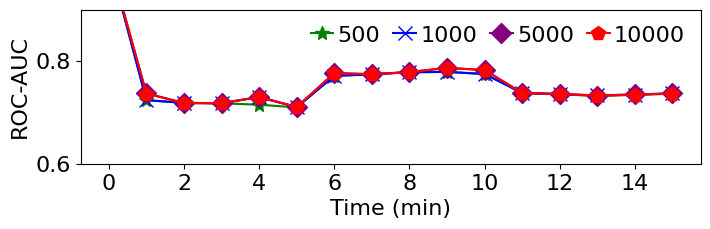

In [20]:
df_plot = values_df.copy(deep=True)
df_plot['id'] = df_plot['threshold']

plot_df = pd.DataFrame(columns=df_plot['threshold'].tolist())
f1s = df_plot['roc_auc'].tolist()
for f1 in f1s:
    print(len(f1))
for i in range(0, 16):
    plot_df.loc[len(plot_df)] = [f1s[0][i], f1s[1][i], f1s[2][i], f1s[3][i]]

fig, ax = plt.subplots(figsize=(8, 2))

colors = ['green', 'blue', 'purple', 'red']
markers = ['*', 'x', 'D', 'p']

for idx, col in enumerate(plot_df.columns):
    plt.plot(plot_df.index, plot_df[col], label=col, color=colors[idx], linewidth=1.5, marker=markers[idx], markersize=10)
plt.legend(ncol=5, loc="best",
           alignment='left', 
           frameon=False, facecolor=(1, 1, 1, 0), 
           edgecolor='black', labelspacing=0.25, columnspacing=0.6, borderpad=0.2, 
           handletextpad=0.2, handlelength=1)
plt.ylim(0.6, 0.9)
plt.xlabel('Time (min)')
plt.ylabel('ROC-AUC')
plt.show()

In [21]:
result_paths = {
    '10': "/mnt/extra/continuous-training/results/1718058413712339701/",
    '50': "/mnt/extra/continuous-training/results/1718056537436439889/",
    '100': "/mnt/extra/continuous-training/results/1718058715771779205/",
}

In [28]:
stats_df = pd.DataFrame(columns=['folder_path', 'algo', 'threshold', 'param_path', 'csv_path', 'latencies_path', 'num_retrain', 'training_time_total', 'training_time_single', 'training_cpu_time', 'training_counter', 'inference_time_total', 'inference_time_single', 'inference_cpu_time', 'inference_counter'])

for key, stat in result_paths.items():
    contents = []
    with open(os.path.join(stat, 'parameters.txt'), "r") as f:
        contents = f.readlines()
    # Iterate to get variables
    folder_path = stat
    algo_name = 'nurd'
    if key != '50':
        csv_path = os.path.join(folder_path, 'model_zoo_estimator_'+str(key)+'.csv')
    else:
        csv_path = os.path.join(folder_path, 'model_zoo_sample_5000.csv')
    latencies_path = os.path.join(folder_path, 'latencies.csv')
    param_path = stat
    valid_entry = False
    retrained = -1
    training_time_total = -1
    training_time_single = -1
    training_cpu_time = -1
    training_counter = -1
    inference_time_total = -1
    inference_time_single = -1
    inference_cpu_time = -1
    inference_counter = -1
    for content in contents:
        if not valid_entry and 'Inference' in content:
            valid_entry = True
        if 'Retrained' in content:
            retrained = float(content.split(' = ')[1].split('\n')[0])
        if 'Training time total' in content:
            training_time_total = float(content.split(' = ')[1].split(' s')[0])
        if 'Training time single' in content:
            training_time_single = float(content.split(' = ')[1].split(' s')[0])
        if 'Training CPU times usage' in content:
            training_cpu_time = float(content.split(' = ')[1].split(' sCPU')[0])
        if 'Training counter' in content:
            training_counter = float(content.split(' = ')[1].split('\n')[0])
        if 'Inference time total' in content:
            inference_time_total = float(content.split(' = ')[1].split(' s')[0])
        if 'Inference time single' in content:
            inference_time_single = float(content.split(' = ')[1].split(' s')[0])
        if 'Inference CPU times usage' in content:
            inference_cpu_time = float(content.split(' = ')[1].split(' sCPU')[0])
        if 'Inference counter' in content:
            inference_counter = float(content.split(' = ')[1].split('\n')[0])
    if valid_entry:
        stats_df.loc[len(stats_df)] = [folder_path, algo_name, key, param_path, csv_path, latencies_path, retrained, training_time_total, training_time_single, training_cpu_time, training_counter, inference_time_total, inference_time_single, inference_cpu_time, inference_counter]
stats_df

,folder_path,algo,threshold,param_path,csv_path,latencies_path,num_retrain,training_time_total,training_time_single,training_cpu_time,training_counter,inference_time_total,inference_time_single,inference_cpu_time,inference_counter
0,/mnt/extra/continuous-training/results/1718058...,nurd,10,/mnt/extra/continuous-training/results/1718058...,/mnt/extra/continuous-training/results/1718058...,/mnt/extra/continuous-training/results/1718058...,0.0,127.106376,8.473758,885.28,15.0,6.371845,4.308535e-07,34.96,14788890.0
1,/mnt/extra/continuous-training/results/1718056...,nurd,50,/mnt/extra/continuous-training/results/1718056...,/mnt/extra/continuous-training/results/1718056...,/mnt/extra/continuous-training/results/1718056...,0.0,120.827388,8.055159,375.82,15.0,7.599934,5.138948e-07,29.58,14788890.0
2,/mnt/extra/continuous-training/results/1718058...,nurd,100,/mnt/extra/continuous-training/results/1718058...,/mnt/extra/continuous-training/results/1718058...,/mnt/extra/continuous-training/results/1718058...,0.0,121.710358,8.114024,697.00,15.0,9.003617,6.088095e-07,45.87,14788890.0


In [29]:
values_df = pd.DataFrame({
    'threshold': pd.Series(dtype='int'),
    'path': pd.Series(dtype='string'),
    'algo': pd.Series(dtype='string'),
    'length': pd.Series(dtype='int'),
    'f1': pd.Series(dtype='object'),
    'roc_auc': pd.Series(dtype='object'),
    'latencies_acc': pd.Series(dtype='object'),
    'latencies_rej': pd.Series(dtype='object'),
    'retrain': pd.Series(dtype='int'),
    'training_time_total': pd.Series(dtype='float'),
    'training_time_single': pd.Series(dtype='float'),
    'training_cpu_time': pd.Series(dtype='float'),
    'training_counter': pd.Series(dtype='int'),
    'inference_time_total': pd.Series(dtype='float'),
    'inference_time_single': pd.Series(dtype='float'),
    'inference_cpu_time': pd.Series(dtype='float'),
    'inference_counter': pd.Series(dtype='int'),
})

for i, row in stats_df.iterrows():
    temp_df = pd.read_csv(os.path.join(row['folder_path'], row['csv_path']), index_col=0)
    temp_df = temp_df.drop_duplicates(subset='minute', keep="last")
    retrain_list = temp_df['retrain'].tolist()
    retrain = [i for i in retrain_list if i==True]
    latencies_df = pd.read_csv(row['latencies_path'], header=None, names=['latency', 'reject'], dtype={'latency': int, 'reject': str})
    latencies_acc = latencies_df[latencies_df['reject'].isin(["0", "True"])]['latency'].tolist()
    latencies_rej = latencies_df[latencies_df['reject'].isin(["1", "False"])]['latency'].tolist()
    # if temp_df['minute'].max() == 480:
    # if i != 3:
    #     values_df.loc[len(values_df)] = [row['folder_path'], row['algo'], temp_df['minute'].max(), temp_df['f1_score'].tolist()[:-5], temp_df['roc_auc'].tolist()[:-5], row['num_retrain'], row['training_time_total'], row['training_time_single'], row['training_cpu_time'], row['training_counter'], row['inference_time_total'], row['inference_time_single'], row['inference_cpu_time'], row['inference_counter']]
    # else:
    values_df.loc[len(values_df)] = [row['threshold'], row['folder_path'], row['algo'], temp_df['minute'].max(), temp_df['f1_score'].tolist(), temp_df['roc_auc'].tolist(), latencies_acc, latencies_rej, row['num_retrain'], row['training_time_total'], row['training_time_single'], row['training_cpu_time'], row['training_counter'], row['inference_time_total'], row['inference_time_single'], row['inference_cpu_time'], row['inference_counter']]

# print(values_df.iloc[13]['path'])
# values_df.drop([13], inplace=True)
values_df.reset_index(inplace=True, drop=True)
values_df.to_csv('values_threshold_estimator_zoo.csv')
values_df

,threshold,path,algo,length,f1,roc_auc,latencies_acc,latencies_rej,retrain,training_time_total,training_time_single,training_cpu_time,training_counter,inference_time_total,inference_time_single,inference_cpu_time,inference_counter
0,10,/mnt/extra/continuous-training/results/1718058...,nurd,30,"[0.9998050883677676, 0.8851192233537225, 0.883...","[0.9996970843857572, 0.7370681222595448, 0.719...","[361, 282, 223, 44, 491, 702, 398, 703, 178, 1...","[463, 382, 572, 590, 454, 464, 527, 200, 335, ...",0.0,127.106376,8.473758,885.28,15.0,6.371845,4.308535e-07,34.96,14788890.0
1,50,/mnt/extra/continuous-training/results/1718056...,nurd,30,"[0.9998050883677676, 0.8850842255422915, 0.883...","[0.9996970843857572, 0.737230988649529, 0.7184...","[361, 282, 223, 44, 491, 702, 398, 703, 178, 1...","[463, 382, 572, 590, 454, 464, 527, 200, 335, ...",0.0,120.827388,8.055159,375.82,15.0,7.599934,5.138948e-07,29.58,14788890.0
2,100,/mnt/extra/continuous-training/results/1718058...,nurd,30,"[0.9998050883677676, 0.8855821598530836, 0.883...","[0.9996970843857572, 0.7238806598276734, 0.718...","[361, 282, 223, 119, 44, 491, 145, 440, 703, 1...","[463, 382, 572, 590, 454, 464, 527, 200, 335, ...",0.0,121.710358,8.114024,697.00,15.0,9.003617,6.088095e-07,45.87,14788890.0


16
16
16


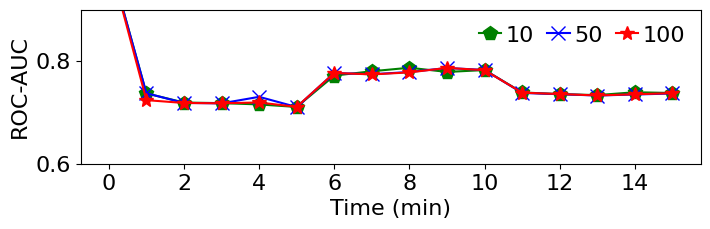

In [33]:
df_plot = values_df.copy(deep=True)
df_plot['id'] = df_plot['threshold']

plot_df = pd.DataFrame(columns=df_plot['threshold'].tolist())
f1s = df_plot['roc_auc'].tolist()
for f1 in f1s:
    print(len(f1))
for i in range(0, 16):
    plot_df.loc[len(plot_df)] = [f1s[0][i], f1s[1][i], f1s[2][i]]

fig, ax = plt.subplots(figsize=(8, 2))

colors = ['green', 'blue', 'red']
markers = ['p', 'x', '*']

for idx, col in enumerate(plot_df.columns):
    plt.plot(plot_df.index, plot_df[col], label=col, color=colors[idx], linewidth=1.5, marker=markers[idx], markersize=10)
plt.legend(ncol=5, loc="best",
           alignment='left', 
           frameon=False, facecolor=(1, 1, 1, 0), 
           edgecolor='black', labelspacing=0.25, columnspacing=0.6, borderpad=0.2, 
           handletextpad=0.2, handlelength=1)
plt.ylim(0.6, 0.9)
plt.xlabel('Time (min)')
plt.ylabel('ROC-AUC')
plt.show()